# Pendahuluan

Proyek ini bertujuan untuk membangun sistem rekomendasi film menggunakan dua pendekatan utama: Collaborative Filtering dan Content-Based Filtering. Dataset yang digunakan berasal dari Kaggle netflix movie rating dataset, yang terdiri dari data rating pengguna dan movie detail.

Sistem ini bertujuan untuk:

- Memberikan rekomendasi film yang relevan bagi pengguna berdasarkan riwayat rating mereka (Collaborative Filtering).

- Memberikan rekomendasi film berdasarkan kemiripan konten (judul) film (Content-Based Filtering).

# import

In [2]:
!pip install numpy==1.24.4 scikit-surprise --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 50.6 MB/s eta 0:00:00
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2461563 sha256=7531f777957997357c0efe215b1932255559fa83defd10ccb3f96d9478f02c5a
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy

**Insight:** menginstall numpy dan scikit-surprise agar tidak conflict

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

**Insight:** Melakukan instalasi paket scikit-surprise untuk algoritma SVD dan import berbagai library untuk analisis data dan modelling.

In [2]:
from google.colab import files
files.upload()  # upload kaggle.json kamu

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
# Download kaggle dataset and unzip the file
# !cp kaggle.json ~/.kaggle/

# !chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d rishitjavia/netflix-movie-rating-dataset
!unzip netflix-movie-rating-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/rishitjavia/netflix-movie-rating-dataset
License(s): CC0-1.0
Archive:  netflix-movie-rating-dataset.zip
  inflating: Netflix_Dataset_Movie.csv  
  inflating: Netflix_Dataset_Rating.csv  


**Insight:**
Mengatur autentikasi dan mengunduh dataset Netflix dari Kaggle. File yang didapat terdiri dari Netflix_Dataset_Movie.csv dan Netflix_Dataset_Rating.csv.



# Data Loading

### Data Rating

In [4]:
rating_df = pd.read_csv('/content/Netflix_Dataset_Rating.csv', header=0)
rating_df

,User_ID,Rating,Movie_ID
0,712664,5,3
1,1331154,4,3
2,2632461,3,3
3,44937,5,3
4,656399,4,3
...,...,...,...
17337453,520675,3,4496
17337454,1055714,5,4496
17337455,2643029,4,4496
17337456,1559566,3,4496


**Insight:**
- Membaca file CSV berisi data rating ke dalam DataFrame.
-   Dataset memiliki 17770 baris (pengamatan) dan 3 kolom.
- User_ID adalah nomer penonton
- Rating adalah penilaian film dari 1-5
- Movie_ID adalah nomer film




### Data Movie

In [7]:
movie_df = pd.read_csv('/content/Netflix_Dataset_Movie.csv', header=0)
movie_df

,Movie_ID,Year,Name
0,1,2003,Dinosaur Planet
1,2,2004,Isle of Man TT 2004 Review
2,3,1997,Character
3,4,1994,Paula Abdul's Get Up & Dance
4,5,2004,The Rise and Fall of ECW
...,...,...,...
17765,17766,2002,Where the Wild Things Are and Other Maurice Se...
17766,17767,2004,Fidel Castro: American Experience
17767,17768,2000,Epoch
17768,17769,2003,The Company


**Insight:**
- Membaca file CSV berisi data movie ke dalam DataFrame.
-   Dataset memiliki 17770 baris (pengamatan) dan 3 kolom.
- Name adalah nama film
- Year adalah tahun film
- Movie_ID adalah nomer film




# Data  Understading

### Data Rating

In [6]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17337458 entries, 0 to 17337457
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   User_ID   int64
 1   Rating    int64
 2   Movie_ID  int64
dtypes: int64(3)
memory usage: 396.8 MB



**Insight:** rating_df memiliki kolom User_ID, Rating, Movie_ID  dan ketganya memiliki type data int64



In [7]:
rating_df.describe()

,User_ID,Rating,Movie_ID
count,1.733746e+07,1.733746e+07,1.733746e+07
mean,1.321158e+06,3.590570e+00,2.302783e+03
std,7.646923e+05,1.062665e+00,1.303458e+03
min,6.000000e+00,1.000000e+00,3.000000e+00
25%,6.602280e+05,3.000000e+00,1.176000e+03
50%,1.316775e+06,4.000000e+00,2.342000e+03
75%,1.983213e+06,4.000000e+00,3.433000e+03
max,2.649429e+06,5.000000e+00,4.496000e+03



**Insight:** rating_df memiliki kolom:
- Count: 17,3 juta rating dari ~2,65 juta pengguna untuk ~4.496 film.
- Mean: Rata-rata User_ID ~1,32 juta, rating 3,59 (skala 1-5), Movie_ID ~2.303.
- Std: Variasi User_ID 764.692, rating 1,06, Movie_ID 1.303, menunjukkan distribusi yang cukup merata.
- Min-Max: User_ID (6 - 2,65 juta), rating (1 - 5), Movie_ID (3 - 4.496).



In [8]:
rating_df.nunique()

,0
User_ID,143458
Rating,5
Movie_ID,1350


Fitur unik:
- User_ID:143458 data
- Rating: Skor penillaian 1-5.
- Movie_ID: 1350 data.

### Data Movie

In [9]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17770 entries, 0 to 17769
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Movie_ID  17770 non-null  int64 
 1   Year      17770 non-null  int64 
 2   Name      17770 non-null  object
dtypes: int64(2), object(1)
memory usage: 416.6+ KB



**Insight:** movie_df memiliki kolom Movie_ID memiliki tipe data int64, Year memiliki tipe data int64, Name memiliki tipe data object


In [10]:
movie_df.describe()

,Movie_ID,Year
count,17770.000000,17770.000000
mean,8885.500000,1990.235566
std,5129.901477,16.564501
min,1.000000,1915.000000
25%,4443.250000,1985.000000
50%,8885.500000,1997.000000
75%,13327.750000,2002.000000
max,17770.000000,2005.000000


Insight:
- Count: 17.770 film.
- Mean: Movie_ID rata-rata 8.885,5; tahun rilis rata-rata 1990,24.
- Std: Variasi Movie_ID 5.129,9; tahun 16,56, menunjukkan sebaran luas.
- Min-Max: Movie_ID (1 - 17.770); tahun (1915 - 2005).

In [11]:
movie_df.nunique()

,0
Movie_ID,17770
Year,91
Name,17297


Fitur:
- Movie_ID: 17770 data ID film.
- Year: 91 jumlah Tahun rilis.
- Name: 17297 data Judul film.

In [12]:
movie_df['Name'].value_counts()

,count
Name,
I,6
The Hunchback of Notre Dame,6
Dr. Quinn,6
Earth,5
Upstairs,5
...,...
Dead Again,1
Walk on Water,1
Teletubbies: The Magic Pumpkin and Other Stories,1


**Insight:** Jumlah data terbayak dari setiap data film

In [6]:
rating_df['Rating'].value_counts()

,count
Rating,
4,5901368
3,5185650
5,3769803
2,1759281
1,721356


### Distribusi Data

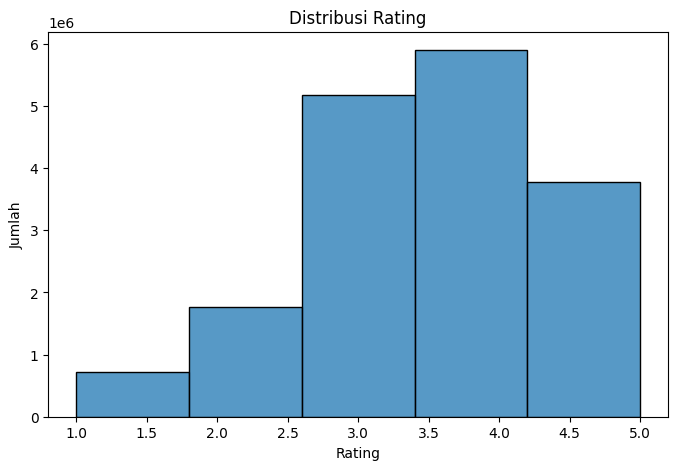

In [13]:
# Distribusi rating
plt.figure(figsize=(8,5))
sns.histplot(rating_df['Rating'], bins=5)
plt.title('Distribusi Rating')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.show()

**Insight:** Jumlah distribusi data menunjukkan banyak data rating bintang 4

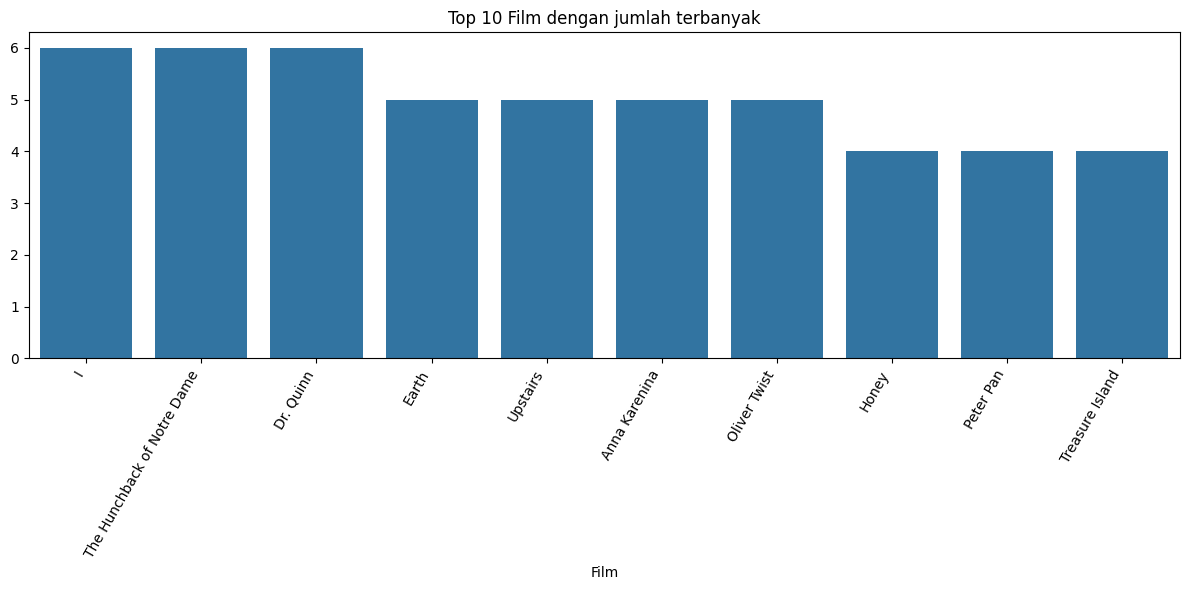

In [9]:
# Gabungkan file rating dan movie
rating_movie = rating_df.merge(movie_df, on='Movie_ID')

top_movies = movie_df['Name'].value_counts().head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=top_movies.index, y=top_movies.values)
plt.title('Top 10 Film dengan jumlah terbanyak')
plt.xlabel('Film')
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

**Insight:** Jumlah distribusi data film jumlah muncul terbanyak.



# Preprocessing

### Memeriksa Null value

In [15]:
rating_df.isnull().sum()

,0
User_ID,0
Rating,0
Movie_ID,0


**Insight:** tidak memiliki data yag kosong pada rating_df

In [16]:
movie_df.isnull().sum()

,0
Movie_ID,0
Year,0
Name,0


**Insight:**ternyata tidak memiliki data kosong pada movie_df

### Memeriksa dupliasi

In [17]:
print(rating_df.duplicated().sum())

0


**Insight:**tidak ada data duplicate pada rating_df

In [18]:
print(movie_df.duplicated().sum())

0


**Insight:**tidak ada data duplicate pada movie_df

### Merge data

In [19]:
df = pd.merge(rating_df, movie_df, on='Movie_ID')
df.head(10)

,User_ID,Rating,Movie_ID,Year,Name
0,712664,5,3,1997,Character
1,1331154,4,3,1997,Character
2,2632461,3,3,1997,Character
3,44937,5,3,1997,Character
4,656399,4,3,1997,Character
5,439011,1,3,1997,Character
6,1644750,3,3,1997,Character
7,2031561,4,3,1997,Character
8,616720,4,3,1997,Character
9,2467008,4,3,1997,Character


**Insight:**Menggbungan data rating_df dan movia_df dan menampilkan 10 data

### Prepare data

In [20]:
# Gunakan hanya kolom yang dibutuhkan
data_df = df[['User_ID', 'Movie_ID', 'Rating']]

# Reader butuh tahu rentang rating
reader = Reader(rating_scale=(1, 5))

# Format data ke dalam objek Dataset surprise
data = Dataset.load_from_df(data_df, reader)

In [21]:
from surprise.model_selection import train_test_split

trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

**Insight:**Menyiapkan data untuk digunakan oleh library Surprise, termasuk membagi ke dalam data latih dan uji.

# Modelling

### Collaborative Filtering - SVD

In [22]:
model = SVD(n_epochs=10,verbose = True)
model.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9


**Insight**
Melatih model SVD dengan epoch=10 dan verbose true

In [23]:
predictions = model.test(testset)

accuracy.rmse(predictions, verbose=True)

RMSE: 0.8689


0.868856355269173

 **Insight:** mengukur performanya menggunakan RMSE terhadap data uji.

In [24]:
# Langkah 1: Ambil semua Movie_ID yang belum di-rating oleh user 712664
user_id = 2643029

# Movie yang sudah dirating oleh user ini
rated_movies = data_df[data_df['User_ID'] == user_id]['Movie_ID'].tolist()

# Movie yang belum dirating
all_movies = data_df['Movie_ID'].unique()
unrated_movies = [movie for movie in all_movies if movie not in rated_movies]

# Langkah 2: Prediksi rating untuk semua movie yang belum dirating
user_predictions = [model.predict(user_id, movie_id) for movie_id in unrated_movies]

# Langkah 3: Ambil top-N (misal 10) dengan rating tertinggi
top_n_preds = sorted(user_predictions, key=lambda x: x.est, reverse=True)[:10]

# Langkah 4: Ambil informasi judul dan tahun dari movie_df
top_n_result = []
for pred in top_n_preds:
    movie_info = movie_df[movie_df['Movie_ID'] == int(pred.iid)].iloc[0]
    top_n_result.append({
        'Year': movie_info['Year'],
        'Name': movie_info['Name'],
        'Estimated_Rating': round(pred.est, 4)
    })

# Langkah 5: Tampilkan hasil rekomendasi
top_n_df = pd.DataFrame(top_n_result)
print(top_n_df)

   Year                                           Name  Estimated_Rating
0  1973                                       Upstairs            4.7530
1  2001                        The West Wing: Season 3            4.7417
2  2004                                 Lost: Season 1            4.7322
3  2003                             Foyle's War: Set 2            4.7148
4  1965                          The Battle of Algiers            4.6892
5  2004          Family Guy: Freakin' Sweet Collection            4.6730
6  1999  Futurama: Monster Robot Maniac Fun Collection            4.6453
7  1994                         The Simpsons: Season 6            4.6383
8  2002                 Curb Your Enthusiasm: Season 3            4.6367
9  1995                            Pride and Prejudice            4.6352


In [25]:
# Langkah 1: Ambil semua Movie_ID yang belum di-rating oleh user 712664
user_id = 43441

# Movie yang sudah dirating oleh user ini
rated_movies = data_df[data_df['User_ID'] == user_id]['Movie_ID'].tolist()

# Movie yang belum dirating
all_movies = data_df['Movie_ID'].unique()
unrated_movies = [movie for movie in all_movies if movie not in rated_movies]

# Langkah 2: Prediksi rating untuk semua movie yang belum dirating
user_predictions = [model.predict(user_id, movie_id) for movie_id in unrated_movies]

# Langkah 3: Ambil top-N (misal 10) dengan rating tertinggi
top_n_preds = sorted(user_predictions, key=lambda x: x.est, reverse=True)[:10]

# Langkah 4: Ambil informasi judul dan tahun dari movie_df
top_n_result = []
for pred in top_n_preds:
    movie_info = movie_df[movie_df['Movie_ID'] == int(pred.iid)].iloc[0]
    top_n_result.append({
        'Year': movie_info['Year'],
        'Name': movie_info['Name'],
        'Estimated_Rating': round(pred.est, 4)
    })

# Langkah 5: Tampilkan hasil rekomendasi
top_n_df = pd.DataFrame(top_n_result)
print(top_n_df)

   Year                      Name  Estimated_Rating
0  2004            Lost: Season 1            4.6203
1  2001   The West Wing: Season 3            4.4517
2  1994    The Simpsons: Season 6            4.4285
3  2004   Stargate SG-1: Season 8            4.4173
4  1995       Pride and Prejudice            4.3864
5  2002   Gilmore Girls: Season 3            4.3832
6  2002                   Firefly            4.3716
7  2001           Alias: Season 1            4.3652
8  2003        Foyle's War: Set 2            4.3650
9  2004  Six Feet Under: Season 4            4.3634


**Insight**: Memprediksi rating untuk film yang belum ditonton oleh user, dan menampilkan rekomendasi 10 film terbaik.



### Evaluasi Collaborative Filtering - SVD

In [26]:
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

print("RMSE:", rmse)
print("MAE:", mae)

RMSE: 0.8689
MAE:  0.6781
RMSE: 0.868856355269173
MAE: 0.6780546805518209


**Insight:** Menghitung metrik RMSE dan MAE untuk mengevaluasi akurasi prediksi model Collaborative Filtering.

### Content-based Filtering

In [27]:
# Pakai hanya film unik
movie_features = movie_df[['Movie_ID', 'Name']].drop_duplicates()
# Hilangkan nilai kosong (jika ada)
movie_features['Name'] = movie_features['Name'].fillna('')
movie_features.sample(5)

,Movie_ID,Name
12503,12504,The Stooge
12897,12898,Fright Night Part II
3682,3683,Gale Force
284,285,The Devil's Own
14146,14147,Catch 22


**Insight:** mengunakan nilai unik saja dan mengganti nilai Nan dengan nilai kosong

In [28]:
# Inisialisasi TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english')

# Melakukan perhitungan idf pada data name
tfidf.fit(movie_features['Name'])

# Transform judul film ke TF-IDF matrix
tfidf_matrix = tfidf.fit_transform(movie_features['Name'])

# Hitung similarity antar film berdasarkan judul
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

**Insight:** Mengubah judul film menjadi representasi numerik menggunakan TF-IDF dan menghitung kesamaan antar film.

In [29]:
# Index dataframe berdasarkan Movie_ID
indices = pd.Series(movie_features.index, index=movie_features['Movie_ID']).drop_duplicates()
movie_id_to_index = dict(zip(movie_features['Movie_ID'], movie_features.index))

**Insight:** Membuat Series yang memetakan Movie_ID ke indeks baris DataFrame movie_features, menghapus duplicate, dan Membuat kamus (dictionary) yang memetakan Movie_ID ke indeks baris DataFrame.

In [30]:
def get_recommendations(movie_id, top_n=10):
    idx = movie_id_to_index.get(movie_id)
    if idx is None:
        return []

    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]

    # Ambil Movie_ID dan Judulnya
    movie_indices = [i[0] for i in sim_scores]
    result = movie_df.iloc[movie_indices][['Movie_ID', 'Name', 'Year']]
    result['Similarity'] = [i[1] for i in sim_scores]
    return result

**Insight:** Fungsi untuk menghasilkan 10 film yang paling mirip dengan film tertentu berdasarkan kemiripan judul.

In [31]:
rekomendasi = get_recommendations(movie_id=3456, top_n=10)  # Ganti ID sesuai kebutuhan
print(rekomendasi)

       Movie_ID                             Name  Year  Similarity
4984       4985                     Lost & Found  1999    0.826104
11693     11694         The Lost World: Season 2  2000    0.794335
17018     17019         The Lost World: Season 1  1999    0.794335
9127       9128          Lost in Space: Season 1  1965    0.740536
8414       8415       Land of the Lost: Season 3  1976    0.717135
16063     16064       Land of the Lost: Season 1  1974    0.717135
16582     16583       Land of the Lost: Season 2  1975    0.717135
956         957  Lost in Space: Season 2: Vol. 1  1966    0.659653
5931       5932  Lost in Space: Season 2: Vol. 2  1966    0.659653
8136       8137  Lost in Space: Season 3: Vol. 2  1968    0.659653


**Insight:** menggunakan fungsi rekomendasi dengan movie_id= dan menampilkan 10 film

In [32]:
movie_df.loc[movie_df['Movie_ID'] == 3456, ['Name', 'Year']]

,Name,Year
3455,Lost: Season 1,2004


**Insight:** menampilkan nama movie_id dengan nomer 3456

### Evaluasi Model Content-based Filtering

*asasasas*

In [33]:
!pip install fuzzywuzzy

**Insight:**
Menggunakan fuzzywuzzy untuk menghitung kesamaan nama antar film secara parsial. Ini digunakan sebagai ground truth untuk mengevaluasi seberapa akurat rekomendasi Content-Based berdasarkan judul mirip.



In [39]:
from fuzzywuzzy import fuzz

# Pilih film acuan
reference_movie_id = 3456  # Movie_ID untuk "Lost: Season 1"
if reference_movie_id in movie_df['Movie_ID'].values:
    reference_idx = movie_id_to_index[reference_movie_id]
    reference_name = movie_df.loc[reference_idx, 'Name']
    print(f"Reference Movie ID: {reference_movie_id}, Name: {reference_name}")

    # Ground truth: film dengan skor kesamaan nama > 80
    # Gunakan apply untuk menghitung skor kesamaan untuk setiap judul
    similarity_scores = movie_df['Name'].apply(lambda x: fuzz.partial_ratio(x, reference_name))
    relevant_movies = set(movie_df[similarity_scores > 80]['Movie_ID'])
    print(f"Jumlah film relevan (nama mirip): {len(relevant_movies)}")

    # Dapatkan rekomendasi
    recommended_df = get_recommendations(reference_movie_id, top_n=10)
    print("Rekomendasi:", recommended_df)
    recommended = set(recommended_df['Movie_ID'])

    # Precision@k
    def precision_at_k(recommended, relevant, k):
        recommended_k = set(list(recommended)[:k])
        return len(recommended_k & relevant) / k if recommended_k else 0

    k = 10
    precision = precision_at_k(recommended, relevant_movies, k)
    print(f"Precision@{k}: {precision:.4f}")

    # Recall@k
    def recall_at_k(recommended, relevant, k):
        recommended_k = set(list(recommended)[:k])
        return len(recommended_k & relevant) / len(relevant) if relevant else 0

    k = 10
    recall = recall_at_k(recommended, relevant_movies, k)
    print(f"Recall@{k}: {recall:.4f}")

    # Hit Rate
    def hit_rate(recommended, relevant):
        return 1 if recommended & relevant else 0

    hit = hit_rate(recommended, relevant_movies)
    print(f"Hit Rate: {hit:.4f}")
else:
    print(f"Movie_ID {reference_movie_id} tidak ditemukan!")

Reference Movie ID: 3456, Name: Lost: Season 1
Jumlah film relevan (nama mirip): 93
Rekomendasi:        Movie_ID                             Name  Year  Similarity
4984       4985                     Lost & Found  1999    0.826104
11693     11694         The Lost World: Season 2  2000    0.794335
17018     17019         The Lost World: Season 1  1999    0.794335
9127       9128          Lost in Space: Season 1  1965    0.740536
8414       8415       Land of the Lost: Season 3  1976    0.717135
16063     16064       Land of the Lost: Season 1  1974    0.717135
16582     16583       Land of the Lost: Season 2  1975    0.717135
956         957  Lost in Space: Season 2: Vol. 1  1966    0.659653
5931       5932  Lost in Space: Season 2: Vol. 2  1966    0.659653
8136       8137  Lost in Space: Season 3: Vol. 2  1968    0.659653
Precision@10: 0.3000
Recall@10: 0.0323
Hit Rate: 1.0000


**Insight:**
- Menentukan film yang dianggap relevan berdasarkan kemiripan judul ≥ 80 menggunakan metode partial_ratio dari fuzzy matching.
- Precision@k mengukur proporsi film yang direkomendasikan dalam top-k dan benar-benar relevan menurut fuzzy matching
- Recall@k mengukur proporsi film relevan yang berhasil ditangkap oleh sistem rekomendasi dalam top-k rekomendasi.
-Hit Rate bernilai 1 jika setidaknya satu film dalam rekomendasi termasuk dalam ground truth (film relevan).